In [1]:
%matplotlib inline
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [10]:
from typing import Optional, Tuple, Dict
import MDAnalysis as mda
from MDAnalysis.analysis.base import AnalysisFromFunction
import numpy as np
import pandas as pd
import os
from polyphys.manage.typer import ParserT
from polyphys.manage.parser import SumRuleCyl, TransFociCyl, TransFociCub
from polyphys.manage.organizer import invalid_keyword, sort_filenames
from polyphys.analyze import clusters
from polyphys.probe.prober import stamps_report
import warnings

In [3]:
from polyphys.manage.parser import HnsCub

In [4]:
# analyzing bug files.
group = 'nucleoid'
lineage = 'whole'
save_to = './'
#macmini_path = "/Users/amirhsi_mini/trjs/epss5.0epsl5.0r10.5al5.0nl5ml125ns200ac1.0nc*lz77.0dt0.005bdump5000adump5000ens1ring/*.bug*"
macbookpro_path = "/Users/amirhsi_mini/research_data/hns_cubic-probe/N200epshm29nh37ac2/N200epshm29nh37ac2nc5969l25dt0.005ndump2000adump5000ens1.ring"
nuc_pairs = glob(macbookpro_path + '/N*' + group + '*')
nuc_pairs = sort_filenames(
    nuc_pairs,
    fmts=['.' + group + '.data', '.' + group + '.lammpstrj']
)

In [5]:
nuc_pairs

[('/Users/amirhsi_mini/research_data/hns_cubic-probe/N200epshm29nh37ac2/N200epshm29nh37ac2nc5969l25dt0.005ndump2000adump5000ens1.ring/N200epshm29nh37ac2nc5969l25dt0.005ndump2000adump5000ens1.ring.nucleoid.data',
  '/Users/amirhsi_mini/research_data/hns_cubic-probe/N200epshm29nh37ac2/N200epshm29nh37ac2nc5969l25dt0.005ndump2000adump5000ens1.ring/N200epshm29nh37ac2nc5969l25dt0.005ndump2000adump5000ens1.ring.nucleoid.lammpstrj')]

In [13]:
topology = nuc_pairs[0][0]
trajectory = nuc_pairs[0][1]
lineage = 'whole'
save_to = './'
continuous = False
if (lineage == 'segment') & (continuous is False):
    warnings.warn(
        "lineage is "
        f"'{lineage}' "
        "and 'continuous' is "
        f"'{continuous}. "
        "Please ensure the "
        f"'{trajectory}' is NOT part of a sequence of trajectories.",
        UserWarning
    )
print("Setting the name of analyze file...")
sim_info = HnsCub(
    trajectory,
    lineage,
    'cubic',
    'nucleoid'
)
sim_name = sim_info.lineage_name + "-" + sim_info.group
print("\n" + sim_name + " is analyzing...\n")
# LJ time difference between two consecutive frames:
time_unit = sim_info.dmon * np.sqrt(
    sim_info.mmon * sim_info.eps_others)  # LJ time unit
lj_nstep = sim_info.ndump  # Sampling steps via dump command in Lammps
lj_dt = sim_info.dt
sim_real_dt = lj_nstep * lj_dt * time_unit
cell = mda.Universe(
    topology, trajectory, topology_format='DATA',
    format='LAMMPSDUMP', lammps_coordinate_convention='unscaled',
    atom_style="id resid type x y z", dt=sim_real_dt
    )
# slicing trajectory based the continuous condition
if continuous:
    sliced_trj = cell.trajectory[0: -1]
    n_frames = cell.trajectory.n_frames - 1
else:
    sliced_trj = cell.trajectory
    n_frames = cell.trajectory.n_frames
# selecting atom groups
bug = cell.select_atoms('resid 1')  # the bug
hns_hole = cell.select_atoms('type 2')  # the hns holes
hns_core = cell.select_atoms('type 3')  # the hns cores

Setting the name of analyze file...


/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/PolyPhys/polyphys/manage/parser.py:1940: UserWarning: It is assumed that 'nc' is the last attribute shortkey in a lineage_name of types: 'ensemble', 'ensemble_long', 'whole', 'segment'.
  warnings.warn(convention_warning, UserWarning)



N200epshm29nh37ac2nc5969l25dt0.005ndump2000adump5000ens1.ring-nucleoid is analyzing...



In [14]:
%%time
# defining collectors
# -bug:
gyr_t = []
principal_axes_t = np.empty([0, 3, 3])
asphericity_t = []
shape_parameter_t = []
for _ in sliced_trj:
    # bug:
    # -various measures of chain size
    gyr_t.append(bug.radius_of_gyration())
    # -shape parameters:
    asphericity_t.append(bug.asphericity(pbc=False, unwrap=False))
    principal_axes_t = np.append(
        principal_axes_t,
        np.array([bug.principal_axes(pbc=False)]),
        axis=0
    )
    shape_parameter_t.append(bug.shape_parameter(pbc=False))
# Saving collectors to memory
# -bug
np.save(save_to + sim_name + '-gyrTMon.npy', np.array(gyr_t))
np.save(save_to + sim_name + '-asphericityTMon.npy',
        np.array(asphericity_t)
        )
np.save(save_to + sim_name + '-principalTMon.npy', principal_axes_t)
np.save(save_to + sim_name + '-shapeTMon.npy', np.array(shape_parameter_t))
# Simulation stamps:
outfile = save_to + sim_name + "-stamps.csv"
stamps_report(outfile, sim_info, n_frames)
print('done.')

done.
CPU times: user 5min 42s, sys: 1.15 s, total: 5min 43s
Wall time: 5min 44s


In [ ]:
for (nuc_topo, nuc_trj) in nuc_pairs:
    prober.hns_nucleoid_cub(
        bug_topo,
        bug_trj,
        lineage,
        save_to = save_to
    )

In [ ]:
gyr = np.loadtxt(gyr_file)
#gyr[:,1] = (gyr[:,1] - gyr[:,1].mean())/ np.var(gyr[:,1])
t_step=1
gyr = gyr[::t_step,:]
#t_i=2.13*10**8
#t_f=2.53*10**8
gyr = pd.DataFrame(gyr, columns=["t", "gyr"])
#gyr = gyr[gyr['t']<=1.03*10**8]
#gyr = gyr.loc[(gyr['t']>=t_i)&(gyr['t']<=t_f),:]
gyr['log_t'] = np.log10(gyr.t)
gyr_mean = gyr['gyr'].mean()
gyr.t.max()

In [15]:
gyr = np.load('./N200epshm29nh37ac2nc5969l25dt0.005ndump2000adump5000ens1.ring-nucleoid-gyrTMon.npy')

In [23]:
sim_real_dt

10.0

In [19]:
gyr = pd.DataFrame(gyr, columns=["gyr"])
#gyr = gyr[gyr['t']<=1.03*10**8]
#gyr = gyr.loc[(gyr['t']>=t_i)&(gyr['t']<=t_f),:]
gyr['t'] = gyr.index * sim_real_dt
gyr['log_t'] = np.log10(gyr.t)
gyr_mean = gyr['gyr'].mean()
gyr.t.max()

/Users/amirhsi_mini/opt/anaconda3/envs/polyLab/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1000000.0

### slicing over different

In [20]:

t_choice = [  # upper 1.03*10**8
    [3*10**6, 2.53*10**8, r'$\Delta t/\tau=25\times 10^7$'],
    [0.03*10**8, 1.03*10**8, r'$\Delta t/\tau=10\times 10^7$'],
    [0.53*10**8, 1.03*10**8, r'$\Delta t/\tau=5\times 10^7$'],
    [0.83*10**8, 1.03*10**8, r'$\Delta t/\tau=2\times 10^7$'],
    [0.93*10**8, 1.03*10**8, r'$\Delta t/\tau=1\times 10^7$'],
    [0.98*10**8, 1.03*10**8, r'$\Delta t/\tau=0.5\times 10^7$'],
    [1.02*10**8, 1.03*10**8, r'$\Delta t/\tau=0.1\times 10^7$']
]
t_choice = [  # upper 2.03*10**8
    [3*10**6, 2.53*10**8, r'$\Delta t/\tau=25\times 10^7$'],
    [1.03*10**8, 2.03*10**8, r'$\Delta t/\tau=10\times 10^7$'],
    [1.53*10**8, 2.03*10**8, r'$\Delta t/\tau=5\times 10^7$'],
    [1.83*10**8, 2.03*10**8, r'$\Delta t/\tau=2\times 10^7$'],
    [1.93*10**8, 2.03*10**8, r'$\Delta t/\tau=1\times 10^7$'],
    [1.98*10**8, 2.03*10**8, r'$\Delta t/\tau=0.5\times 10^7$'],
    [2.02*10**8, 2.03*10**8, r'$\Delta t/\tau=0.1\times 10^7$']
]
t_choice = [  # upper 1.53*10**8
    [3*10**6, 2.53*10**8, r'$\Delta t/\tau=25\times 10^7$'],
    [0.53*10**8, 1.53*10**8, r'$\Delta t/\tau=10\times 10^7$'],
    [1.03*10**8, 1.53*10**8, r'$\Delta t/\tau=5\times 10^7$'],
    [1.33*10**8, 1.53*10**8, r'$\Delta t/\tau=2\times 10^7$'],
    [1.43*10**8, 1.53*10**8, r'$\Delta t/\tau=1\times 10^7$'],
    [1.48*10**8, 1.53*10**8, r'$\Delta t/\tau=0.5\times 10^7$'],
    [1.52*10**8, 1.53*10**8, r'$\Delta t/\tau=0.1\times 10^7$']
]

In [30]:
t_choice = [  # upper 1.53*10**8
    [0, 10*10**5, r'$\Delta t/\tau=25\times 10^7$'],
    [5*10**5, 10*10**5, r'$\Delta t/\tau=10\times 10^7$'],
    [1*10**5, 5*10**5, r'$\Delta t/\tau=5\times 10^7$'],
    [5*10**4, 10*10**4, r'$\Delta t/\tau=2\times 10^7$'],
    [2.5*10**4, 5*10**4, r'$\Delta t/\tau=1\times 10^7$'],
    [1.25*10**4, 2.5*10**4, r'$\Delta t/\tau=0.5\times 10^7$'],
    [0, 10**5, r'$\Delta t/\tau=0.1\times 10^7$']
]

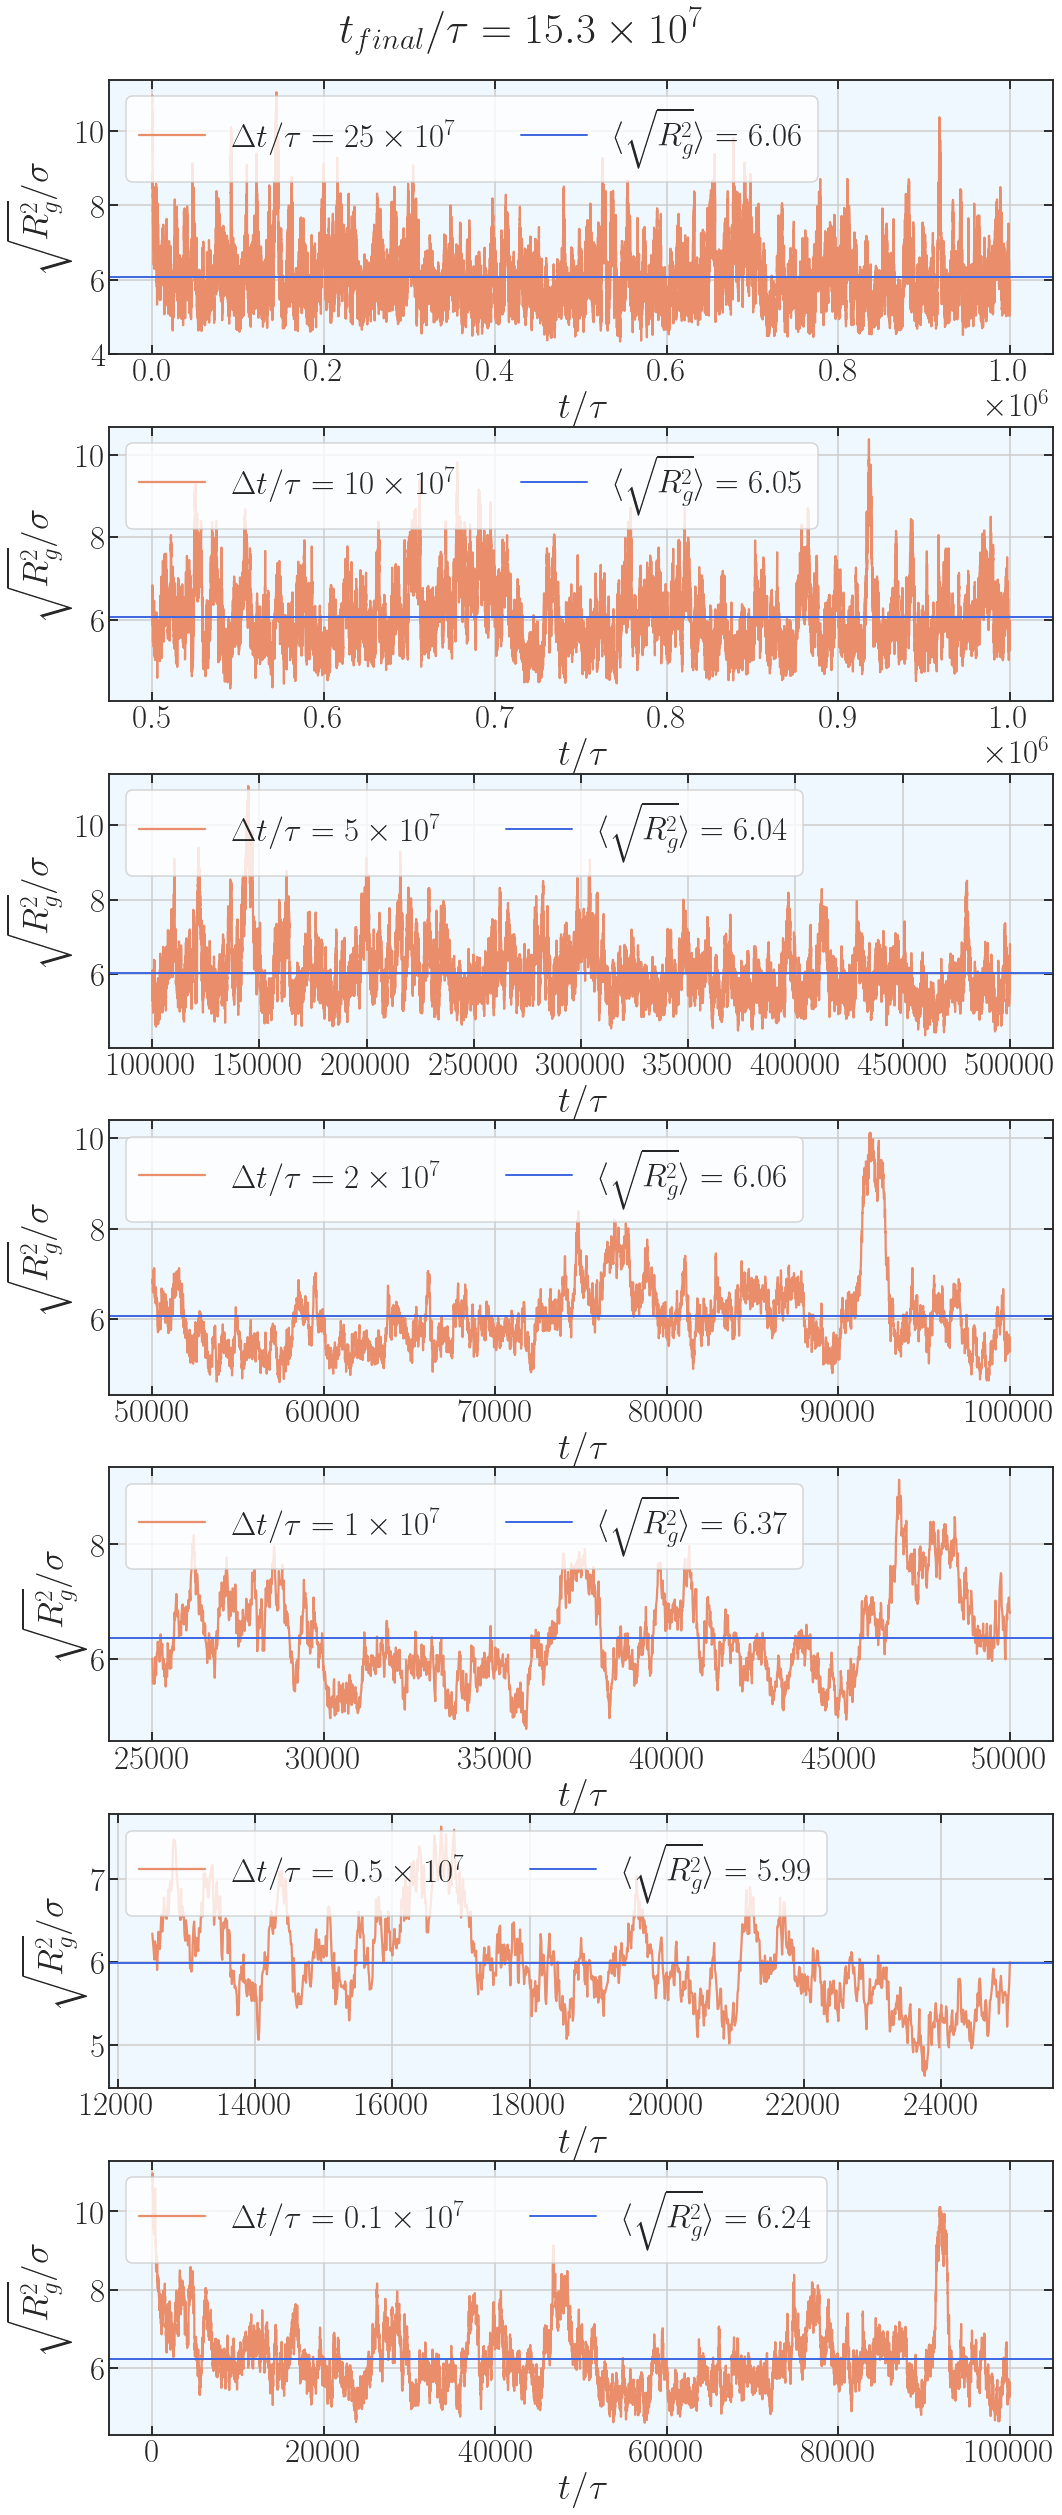

In [31]:
fig, axes = plt.subplots(7,1, figsize=(16,36))
fig.suptitle(r"$t_{final}/\tau=15.3\times 10^7$",y=0.98)
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    'axes.grid.which': 'both',
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
}
font_family = 'sans-serif'
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
for ax, (t_i, t_f, dt) in zip(axes,t_choice):
    gyr_sliced = gyr.loc[(gyr['t']>=t_i)&(gyr['t']<=t_f),:]
    gyr_mean = np.round(gyr_sliced['gyr'].mean(),2)
    ax = sns.lineplot(
        data=gyr_sliced,
        x='t',
        y='gyr',
        ci=None,
        palette=color_palette,
        ax=ax,
        label=dt,
    )
    ax.axhline(
        gyr_mean, color='royalblue',
        label=rf'$\langle \sqrt{{R^2_g}}\rangle={gyr_mean}$', 
        lw=2, ls='-'
    )
    ax.legend(facecolor='white', loc='upper left', ncol=2)
    ax.set_ylabel(r'$\sqrt{R^2_g}/\sigma$')
    ax.set_xlabel(r'$t/\tau$')
fig.tight_layout(w_pad=1, h_pad=0)
plt.show()
fig.savefig("gyrTDna-slices.pdf")

### Semi-log to show reaching equilibrium

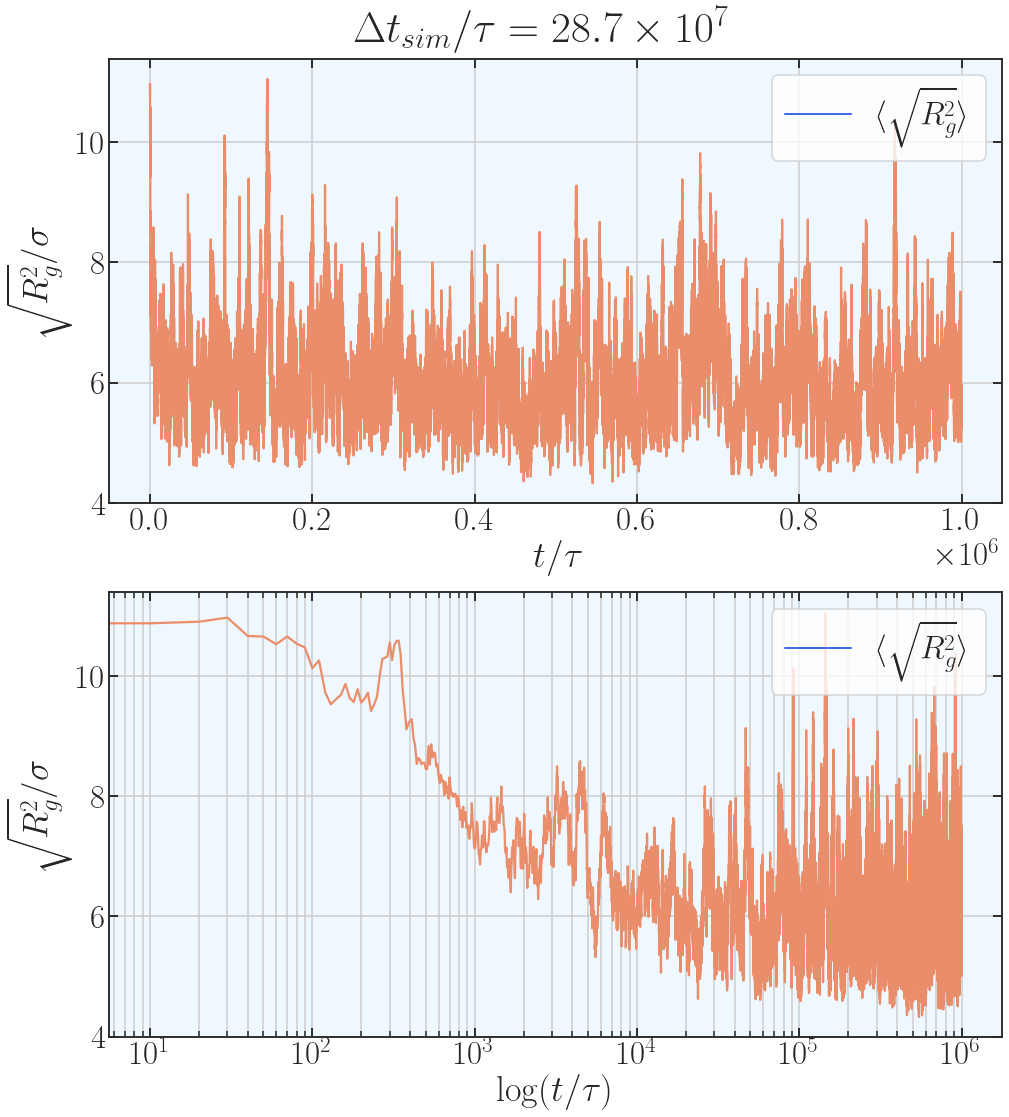

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(16,18))
color_palette = 'flare'
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    'axes.grid.which': 'both',
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
}
font_family = 'sans-serif'
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
axes[0] = sns.lineplot(
    data=gyr,
    x='t',
    y='gyr',
    ci=None,
    palette=color_palette,
    ax=axes[0]
)
fig.suptitle(r"$\Delta t_{sim}/\tau=28.7\times 10^7$",y=0.92)
axes[0].set_xlabel(r'$t/\tau$')
axes[0].axhline(gyr_mean, color='royalblue', label=r'$\langle \sqrt{R^2_g}\rangle$', 
                lw=2, ls='-')
axes[0].legend(facecolor='white', loc='upper right')
axes[0].set_ylabel(r'$\sqrt{R^2_g}/\sigma$')
axes[1].semilogx(
    gyr['t'],
    gyr['gyr']
)
axes[1].set_xlabel(r'$\log(t/\tau)$')
axes[1].axhline(gyr_mean, color='royalblue', label=r'$\langle \sqrt{R^2_g}\rangle$', 
                lw=2, ls='-')
axes[1].legend(facecolor='white', loc='upper right')
axes[1].set_ylabel(r'$\sqrt{R^2_g}/\sigma$')
plt.show()
fig.savefig("gyrTDna-semiLogX.pdf")